In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
#read in data file and skip to data
file=open("/Users/Roslyn/Desktop/run-XXXII", "r")

In [3]:
with file as f:
    lines_after_6 = f.readlines()[7:]

In [4]:
#extract first two coloumns and convert to float
col1=[]
for x in lines_after_6:
    col1.append(float(x.split()[0]))
        
col2=[]
for x in lines_after_6:
    col2.append(float(x.split()[1]))
    
#combine real and imaginary parts to give list of complex data outputs
data=np.vectorize(complex)(col1, col2)

In [5]:
#enter constants
f_mode1 = 4.993017E6
f_mode2 = 5.505658500E+6 #- 2.8
kappa_1 = 0.000576417
kappa_2 = 0.000619449
Q1 = 4.4E7
Q2 = 4.84E7
dt=0.01
fs=100

w_mode1= 2*np.pi*f_mode1
w_mode2= 2*np.pi*f_mode2
tau1=Q1/w_mode1
tau2=Q2/w_mode2

h0=0.0005
trap=0.848

Zsquid= 1.2e6

In [6]:
data1=data[:10000000]

In [7]:
print(len(data))

24089000


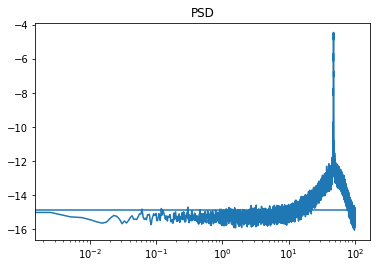

In [8]:
#PSD using Welch method 
f_1, S_1 = welch(
        (data1)-np.mean(data1), fs=fs, nperseg=(len(data1)/256),
         return_onesided=False, detrend=None, scaling='density', window='hanning')

#to plot log log have shifted frequency axis to positive 
plt.plot(f_1+abs(np.min(f_1)), 10*np.log10(S_1))
plt.title('PSD')
plt.xscale('log')


In [9]:
#SPECTRAL DISPLACEMENT DENSITY Su
#eq (8) GW Summary

#omega frequency axis, add mode freq 1 and convert from Hz to rad/s, and create squared axis 
w_1= [(x+f_mode1)*(2*np.pi) for x in f_1]
w_1sq= [x**2 for x in w_1]

#multiply 1/omega^2 list and Sv 
product1= [(1/a) * b for a, b in zip(w_1sq, S_1)]
 
#put into equation for Su(omega)
#10^-6 squared is a conversion from micro V to V
constants1 = (1/kappa_1**2)*(1/(Zsquid**2)*(10**(-6))**2)
Su1 = [x*(constants1) for x in product1]

In [10]:
#transfer function (equation 6 GW Summary)
def trans1(w):
    return np.absolute(((-w)**2*h0*trap/2)/((w*1j)**2+(w*1j)/tau1+w_mode1**2))

In [11]:
H_1=np.array(list(map(trans1,2*np.pi*(f_1+f_mode1))))

Text(0.5, 1.0, 'Transfer Function')

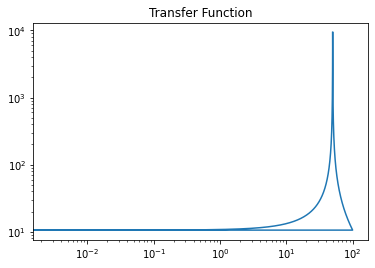

In [12]:
plt.plot(f_1+abs(np.min(f_1)), H_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Transfer Function')

Text(0.5, 1.0, 'Strain Sensitivity ')

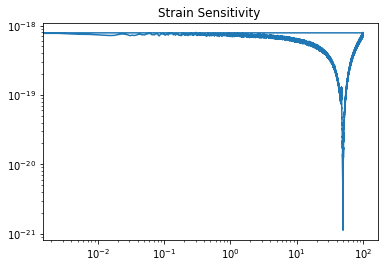

In [13]:
h_1=np.sqrt(Su1)/H_1

plt.plot(f_1+abs(np.min(f_1)), h_1)
plt.xscale('log')
plt.yscale('log')
plt.title('Strain Sensitivity ')

In [14]:
#convert Su back to complex time series 
Su1i=np.fft.ifft((np.sqrt(Su1)))
print(Su1i[:10])

[9.32643030e-18-2.21110487e-35j 7.97509365e-19-2.42114962e-20j
 1.65536730e-19-4.90393567e-20j 1.41131683e-19-7.28325971e-20j
 1.24751818e-19-8.93119340e-20j 1.11686640e-19-1.04711944e-19j
 8.98550082e-20-1.14201619e-19j 6.59522747e-20-1.25391342e-19j
 4.34246088e-20-1.31063251e-19j 2.45187356e-20-1.32539563e-19j]


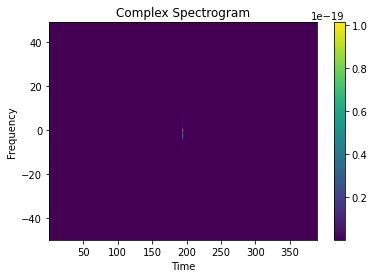

In [15]:
#complex data spectrogram
f, t, Sxx = signal.spectrogram(Su1i-np.mean(Su1i), 100, nperseg=100, return_onesided=False, mode='complex')
plt.pcolormesh(t, fftshift(f), fftshift(abs(Sxx)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Complex Spectrogram')
plt.show()

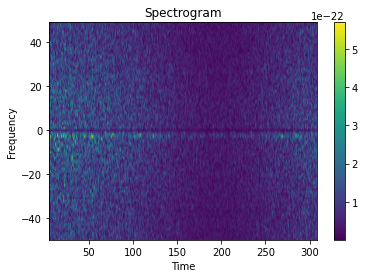

In [16]:
#extract section without power spike 
SxxA=np.array(Sxx)
SxxC= SxxA[0:100,4:350]

difft=np.delete(t[4:351],0)

plt.pcolormesh(difft, fftshift(f), fftshift(abs(SxxC), axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Spectrogram')
plt.show()

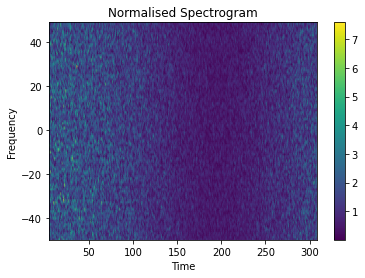

In [17]:
#FIND THRESHOLD NOISE AMPLITUDE AT FREQUENCY AWAY FROM RESONANT MODE 

#normalise data spectrogram 
absnormSxx=[]

for i in range(0,len(SxxC)):
    absnormSxx.append(abs((SxxC[i]/np.median(abs(SxxC[i])))))
    
plt.pcolormesh(difft, fftshift(f), fftshift(absnormSxx, axes=0), shading='gouraud')
plt.colorbar()
#plt.xlim(0,350)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Normalised Spectrogram')
plt.show()

In [18]:
#differencing for data spectrogram (D for data)

timecolsD=np.transpose(absnormSxx)

absdiffD=[]
slice1=[]

for j in range(0,len(absnormSxx)):
    slice1.clear()
    for i in range(0,(len(absnormSxx[0])-1)):
        slice1.append(abs(timecolsD[i+1][j]-timecolsD[i][j]))
    absdiffD.append(slice1[:])
    
#print(len(absdiffD))
#print(len(absdiffD[0]))

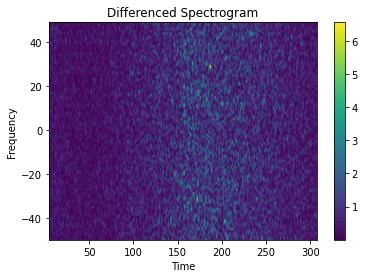

In [19]:
difftD=np.delete(t[4:350],0)

plt.pcolormesh(difftD, fftshift(f), np.array(fftshift(absdiffD)), shading='gouraud')
plt.colorbar()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.title('Differenced Spectrogram')
plt.show()

In [20]:
#select area away from res mode and find max amplitude (around 25-40Hz)

#this corresponds to frequency index approx 26-41
#print(np.shape(absdiffD))
#print(f)
absdiffDA=np.array(absdiffD)

noiserows=absdiffDA[26:41,:].copy()
print(np.shape(noiserows))

threshold=np.amax(noiserows)
print(threshold)

(15, 345)
6.5564530482102565


In [21]:
print(np.amax(absdiffD))
print(np.argmax(absdiffD))

6.5564530482102565
10040


In [22]:
#create loop which essentially completes transient difference 
#test for 100 delta functions 
#at each of a range of h amplitudes 
#to count if they are above threshold 

In [23]:
#(range and arange don't work well with non integer values)
h=np.linspace(1e-26,1e-25,10)
#print(len(h))
#print(h)

In [24]:
#create simulated transient for each h amplitude and resample 
#to match dimension of spec to add
Su_sim=[]
slice2=[]

for i in range(0,len(h)):
    slice2.clear()
    for j in range(0,len(H_1)):
        slice2.append((h[i]*abs(H_1[j])))
    Su_sim.append(signal.resample(slice2[:],len(f)))
    #Su_sim.append(slice2[:])
        
print(np.shape(Su_sim))
#print(len(Su_sim))
#print(len(Su_sim[0]))
#print(Su_sim)

(10, 100)


In [25]:
Su_simUS=[]
slice2US=[]

for i in range(0,len(h)):
    slice2US.clear()
    for j in range(0,len(H_1)):
        slice2US.append((h[i]*abs(H_1[j])))
    Su_simUS.append(slice2US[:])

Text(0.5, 1.0, 'Transient Sim Spectral Displacement Density')

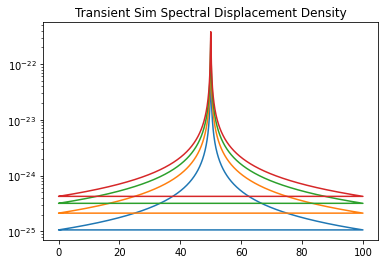

In [26]:
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[0])
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[1])
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[2])
plt.plot(f_1+abs(np.min(f_1)), Su_simUS[3])
#plt.xscale('log')
plt.yscale('log')
plt.title('Transient Sim Spectral Displacement Density')

#transient shape before resampling looks to be correct 

In [27]:
import random

In [28]:
count=0
allcounts=[]

for y in range(0,len(h)):
    for x in range(0,100):
        randomcol=random.randint(0,(len(SxxC[0])-1))
        #print(randomcol)
        SxxC[:,randomcol]= [a+b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]
    
        absnormSxxsim=[]

        for k in range(0,len(SxxC)):
            absnormSxxsim.append(abs((SxxC[k]/np.median(abs(SxxC[k])))))
    
        #print(absnormSxxsim[0][0])
    
        timecols=np.transpose(absnormSxxsim)
        absdiff=[]
        slice3=[]

        for j in range(0,len(absnormSxxsim)):
            slice3.clear()
            for i in range(0,(len(absnormSxxsim[0])-1)):
                slice3.append(abs(timecols[i+1][j]-timecols[i][j]))
            absdiff.append(slice3[:])
    
        #print(absdiff[0][0])
    
        maxamp=np.amax(absdiff)
        print(maxamp)
    
        if maxamp > threshold:
            count+=1
    
        SxxC[:,randomcol]= [a-b for a,b in zip(SxxC[:,randomcol],Su_sim[y])]

    allcounts.append(count)
    count=0


#print(count)
print(allcounts)
    

    
   

6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482

6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.878232131211796
6.5564530482102565
6.674432842965137
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
7.207317477890312
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102565
6.5564530482102

8.242299916956963
10.053841195697228
9.8978568753746
9.95649526722812
9.166683229514245
8.956998695973036
10.08050745999033
8.427848002433429
9.467628230293963
9.49697655859013
9.034698994769146
9.406033811262889
9.095934938166343
10.616789495374634
8.622569665194353
8.292626965473051
8.956998695973036
10.1304864615831
9.010562074888576
9.904877652707212
9.030113150827269
10.349433930978655
12.816194570281166
8.498379737814398
11.75348289085014
11.42810850554997
8.223234477186066
12.290028171185726
8.672658436748634
11.708382780742243
12.085843003784017
13.563809910015834
10.84460944080486
10.514586292499006
9.104447506601609
9.547752442513527
8.698615349553345
10.889671905028708
10.620279917479087
10.775106312013612
6.62616309323894
10.61479704384631
10.221131637576383
9.304157318229983
11.41632827419066
8.182494815860688
10.74427218362822
8.672658436748634
12.691255359166016
12.443765165157718
9.96190478363939
7.298910006844697
9.460220255081017
9.839975201688613
11.022626916564809
6

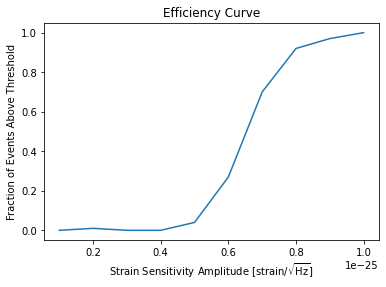

In [29]:
fraccounts=[x/100 for x in allcounts]

plt.plot(h,fraccounts)
plt.title('Efficiency Curve')
plt.xlabel('Strain Sensitivity Amplitude [strain$/\sqrt{\mathrm{Hz}}]$')
plt.ylabel('Fraction of Events Above Threshold')
plt.savefig('ECstrain.png', format='png')
plt.show()
#plt.ylim(0,1)

In [30]:
peakSusim=[]


for i in range(0,len(Su_sim)):
    peakSusim.append(np.amax(Su_sim[i]))
    
print(peakSusim)

[3.0353171317858067e-23, 6.070634263571613e-23, 9.105951395357418e-23, 1.2141268527143227e-22, 1.5176585658929032e-22, 1.8211902790714835e-22, 2.1247219922500646e-22, 2.4282537054286453e-22, 2.731785418607226e-22, 3.0353171317858065e-22]


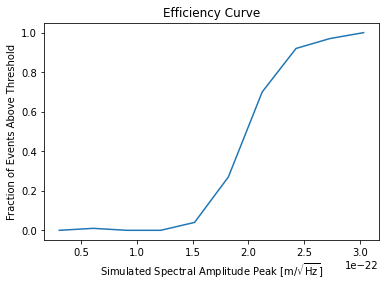

In [31]:
plt.plot(peakSusim, fraccounts)
plt.title('Efficiency Curve')
plt.xlabel('Simulated Spectral Amplitude Peak $[\mathrm{m}/\sqrt{\mathrm{Hz}}]$')
plt.ylabel('Fraction of Events Above Threshold')
#plt.ylim(0,1)
plt.savefig('ECreport.png', format='png')
plt.show()

In [32]:
print(h)

[1.e-26 2.e-26 3.e-26 4.e-26 5.e-26 6.e-26 7.e-26 8.e-26 9.e-26 1.e-25]
